# Gavin Kendal-Freedman

## Research question/interests

**My main interest is how different chemicals effect air quality ratings, specifically the main hazardous components in fuels for motor vehicles or stoves like natural gas/gasoline/diesel fuels (benzene, toluene, propane, methane, sulfurs/oxides of nitrogens, 2,2,4-Trimethylpentane (octane from standard gasoline)), and also potentially common organic solvents/reagents that are used in manufacturing (methacrylates, chloroform/methyl chloroform, acetylene, nitric acid), and how these different particulates effect AQI. Further, I want to see if there is a significant difference in air quality change across time in urban vs rural areas (not just if urban areas have better/worse air quality), based on specific particulates in the first part, and if there is any correlations between asthma rates in different areas and the levels of pollutants there (not across time because the asthma data does not have a time series attached to it).**

### Rough Plan for Data Analysis

1. (Already done as part of loading) Combine all EPA data files into one dataframe
1. Remove all rows that do not contain the parameters of interest (see above)
1. Remove columns that are mostly null/na/nan/missing values or are not interesting to the analysis
1. For locations that have multiple observations for a parameter in a year, average them and all statistics about the measurements for the year
1. Isolate a single metric for each parameter of interest (preferably "Observed Values"), preferably an overall average for the year and not the mean for daily maximums
1. Check for any correlations between the parameters of interest to other parameters of interest, and the AQI
1. Check changes in concentrations over time and see if there are any correlations between the changes in concentrations and the AQI
1. Geo-plot the change in AQI over time for each location, with an overlay showing the change in a normalization and aggregation of the parameters of interest
1. For 2020, geo-plot the AQI and the parameters of interest for each location and overlay the asthma rates for each location

---

### Rough Draft of Final analysis:

Looking at the US as a whole, from the [heatmap](/images/gavin-heatmap.png), the Air Quality is most directly died to Ozone, Carbon Monoxide, and Nitro ($\text{NO}_x$) compounds, with a lower dependence on Sulfur Dioxide, a common output from burning certain fuels like diesel and some natural gasses.

Looking at the [plot](/images/gavin-plot-1.png) of Max AQI against Crude Asthma prevalence, there is a relation that can be seen in certain areas between asthma and AQI, in Washington, Oregon, Arizona, and New Mexico. However, looking on the eastern portion of the US, AQI is much lower, but on the states west of the eastern coast states, a band of relatively higher asthma prevalence can be seen, indicating that AQI is a bad predictive index for asthma on it own. Further, AQI tends to be higher on the west coast, due to the more frequent and large wildfire events<sup>[1]</sup> on the west coast, especially in 2020<sup>[2]</sup>, causing sampling bias in the AQI data. Furthermore, it was noticed that certain places reported AQI of over 500, the maximum value of the US scale, and as such, those values were set to `501`, to differentiate them from values of `500`.

Comparing the different aggregated parameters on the [heatmap](/images/gavin-heatmap.png) for 2020 comes the next analysis and [plot](/images/gavin-plot-2.png), Which shows using medium AQI a more representative idea of the parameters the affect asthma and air quality. Comparing asthma data to median AQI shows a stronger corelation, but not enough to be able to judge direct corelation between AQI and asthma prevalence. However, the correlations between AQI and the aggregated parameters seen in the heatmap can be confirmed from this plot, especially in industrial regions like the midwestern, eastern, and southwestern regions of the US. Overall the northwestern US seems to follow the same trends to a lesser extent, sometimes deviating from the trends, especially in urban areas, and certain areas of the US have little to no data, like the northern region of the central US. Analyzing the parameters against asthma shows few correlations, but the ones that exist are fairly strong, with Ozone, Nitrous compounds, and carbon monoxide, all showing fairly strong positive correlations, especially in the corn and tornado belts/alleys of the US.

Finally, the last [plot](/images/gavin-plot-3.png) shows median AQI across time, which shows that over time, there are fluctuations across the country across years, but the northwest trends to slightly lower AQI levels, and the east trends to slightly higher AQI levels, but overall AQI tends to have stayed fairly steady year to year at median<sup>[3]</sup> readings from year to year. 

---
##### Footnotes

1. [2020 Western US Wildfire Season](https://en.wikipedia.org/wiki/2020_Western_United_States_wildfire_season) - While Wikipedia is not a primary source, it has aggregated information about the extent of wildfires this year, and more complete information is available on the internet if the reader wishes to go into more detail. The exacts of the wildfires are not important for the data analysis here, just that the AQI is highly sample biased on the west coast for 2020.

2. Given the wildfires and as such sampling bias issues identified, the reader may ask why 2020 was chosen as the year for air quality. The asthma data released by the CDC was only for the year 2020 and as such, the most representative year to compare it to air quality was 2020, other years may have different measurements of other populations which could skew analysis further, and since the main particulates from wildfire smoke (PM2.5, PM10, and $\text{CO}_2$) are not being analyzed here, the wildfires will not effect the analysis very much overall.

3. Median readings were chosen here over Max AQI to limit the effects of wildfires as discussed above.

---

In [1]:
from importlib.util import find_spec as _spec
USE_CACHED = True
RELOAD_UTILS = True
ARROW_INSTALLED = bool(_spec("pyarrow"))
PYOGRIO_INSTALLED = bool(_spec("pyogrio"))
gpd_read_args = {} 
if PYOGRIO_INSTALLED:
    gpd_read_args |= {"engine":"pyogrio", "use_arrow": ARROW_INSTALLED}

In [20]:
# Imports
from itertools import chain
from typing import TYPE_CHECKING

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyproj import CRS

# this is a little bit of a hack to get typing hints for the projects function code since
# relative imports won't work properly and the runtime solution doesn't work
# for static analysis (type checking) since its not runtime
if TYPE_CHECKING:
    from .code import project_functions1 as utils
else:
    __import__("sys").path.append("./code") # add the code folder to path
    import project_functions1 as utils

In [16]:
# Setup seaborn/geoplot/matplotlib theme/plotting information
sns.set_theme(style="darkgrid", font_scale=1.5) # type: ignore
projection=gcrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795)
crs = CRS.from_user_input("EPSG:4269")

In [4]:
# Load the data using the function
if RELOAD_UTILS:
    from importlib import reload

    reload(utils)
if USE_CACHED and (utils.PROJECT_ROOT / "data/processed/processed1.csv").exists():
    df = utils.load_preprocessed_1(
        utils.PROJECT_ROOT / "data/processed/geodata1.geojson",
        utils.PROJECT_ROOT / "data/processed/processed1.csv",
        use_pyarrow=ARROW_INSTALLED,
        gpd_kwargs=gpd_read_args,
    )
else:
    df: gpd.GeoDataFrame = utils.load_and_process(
        range(2011, 2023), use_pyarrow=ARROW_INSTALLED, gpd_kwargs=gpd_read_args
    )
if USE_CACHED and (utils.PROJECT_ROOT / "data/processed/heath1.geojson").exists():
    healthdata = utils.load_preprocessed_2(utils.PROJECT_ROOT / "data/processed/heath1.geojson", gpd_kwargs=gpd_read_args)
else:
    healthdata = utils.load_and_process_healthdata(use_pyarrow=ARROW_INSTALLED)
shapedata: gpd.GeoDataFrame = gpd.read_file(utils.PROJECT_ROOT / "data/raw/contiguous-usa.geojson", **gpd_read_args)  # type: ignore

In [5]:
df2 = (
    df.pivot_table(
        values=["Arithmetic Mean"],  # pyright: ignore
        columns=["Parameter Name"],
        index=["CBSA Name", "Year"],
    )
    .droplevel(0, axis=1)
    .merge(
        df.drop(columns=["Arithmetic Mean", "Parameter Name"]),
        how="left",
        left_index=True,
        right_on=["CBSA Name", "Year"],
    )
).set_index(["Year", "CBSA Name"])
df2 = gpd.GeoDataFrame(df2, geometry=df2.geometry)  # type: ignore

In [9]:
parameters = [
    "Median AQI",
    "Ozone",
    "Ammonium compounds",
    "Carbon monoxide",
    "Heavy Metals",
    "Nitric oxides",
    "Nitrogen dioxide (NO2)",
    "Sulfur dioxide",
    "Various Particulates",
    "Benzenes",
]


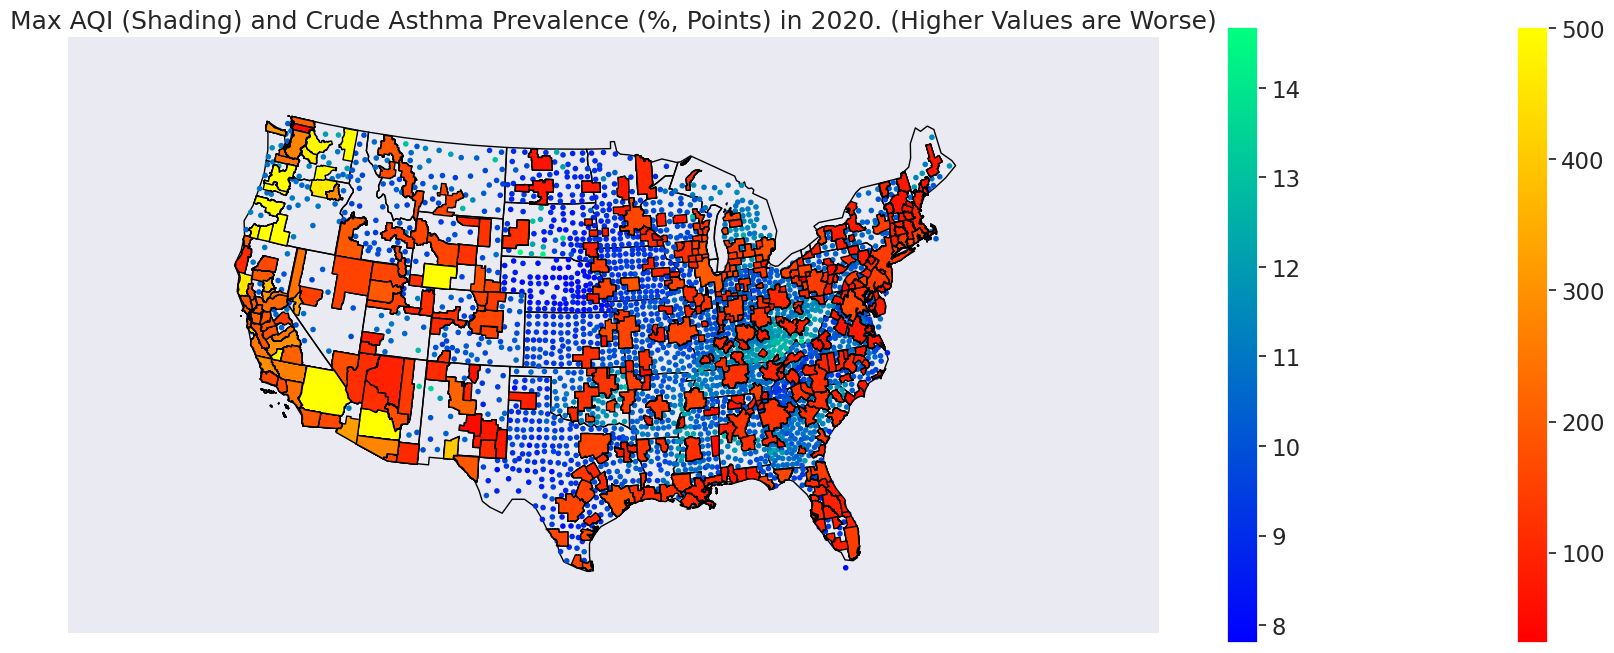

In [10]:
health_scatter = gplt.polyplot(shapedata, figsize=(22,8), projection=projection)
gplt.choropleth(
    df2.dropna(subset="Max AQI").loc[2020],
    hue="Max AQI",
    legend=True,
    ax=health_scatter,
    edgecolor="black",
    linewidth=1,
    cmap="autumn",
    projection=projection,
)
gplt.pointplot(
    healthdata,
    projection=projection,
    hue="Percentage",
    scale="Percentage",
    legend_var="hue",
    legend=True,
    limits=(3,3),
    cmap="winter",
    ax=health_scatter,
)
health_scatter.set_title("Max AQI (Shading) and Crude Asthma Prevalence (%, Points) in 2020. (Higher Values are Worse)")
None

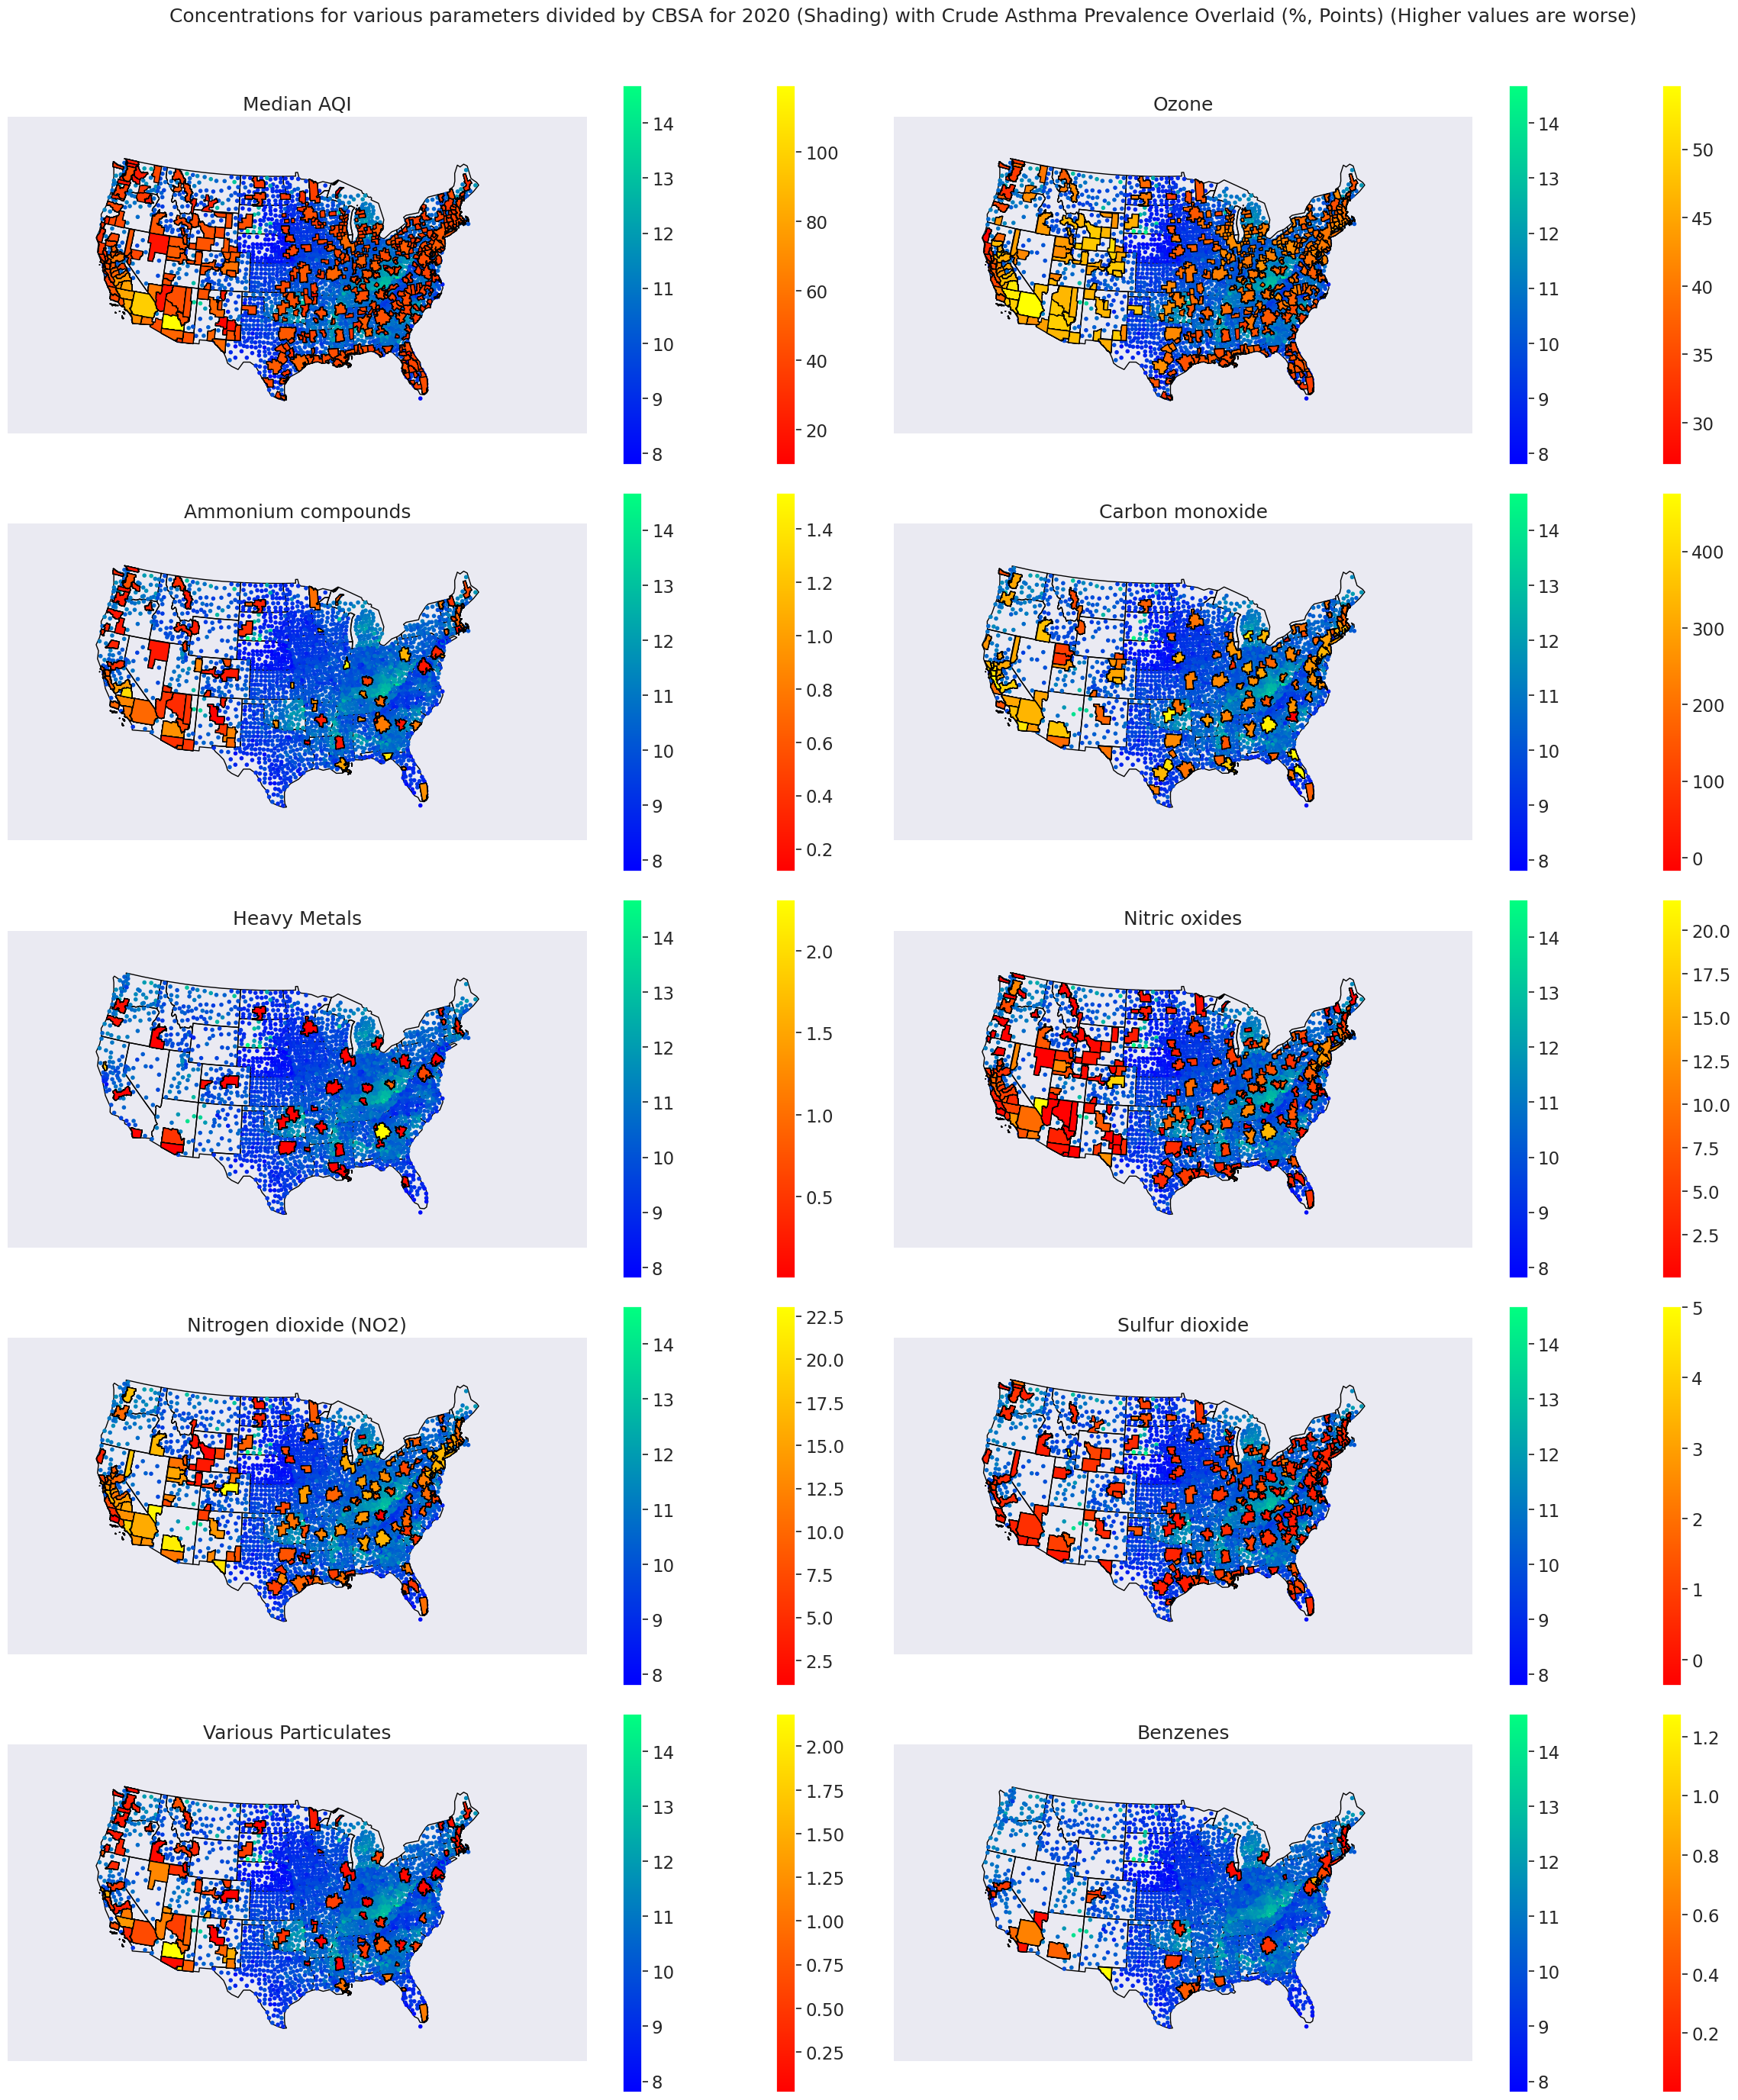

In [11]:
fig, axarr = plt.subplots(
    5,
    2,
    figsize=(24, 28),
    subplot_kw={"projection": projection},
    sharex=True,
    sharey=True,
    squeeze=True,
)
for param, ax in zip(parameters, chain.from_iterable(axarr)):
    gplt.polyplot(shapedata, ax=ax)
    gplt.choropleth(
        df2.dropna(subset=param).loc[2020],
        hue=param,
        legend=True,
        ax=ax,
        edgecolor="black",
        linewidth=1,
        cmap="autumn",
    )
    gplt.pointplot(
        healthdata,
        projection=projection,
        hue="Percentage",
        scale="Percentage",
        legend_var="hue",
        legend=True,
        limits=(3, 3),
        cmap="winter",
        ax=ax,
    )
    ax.set_title(label=param, fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle(
    "Concentrations for various parameters divided by CBSA for 2020 (Shading) with Crude Asthma Prevalence Overlaid (%, Points) (Higher values are worse)",
    va="baseline",
    fontsize=18,
)
None

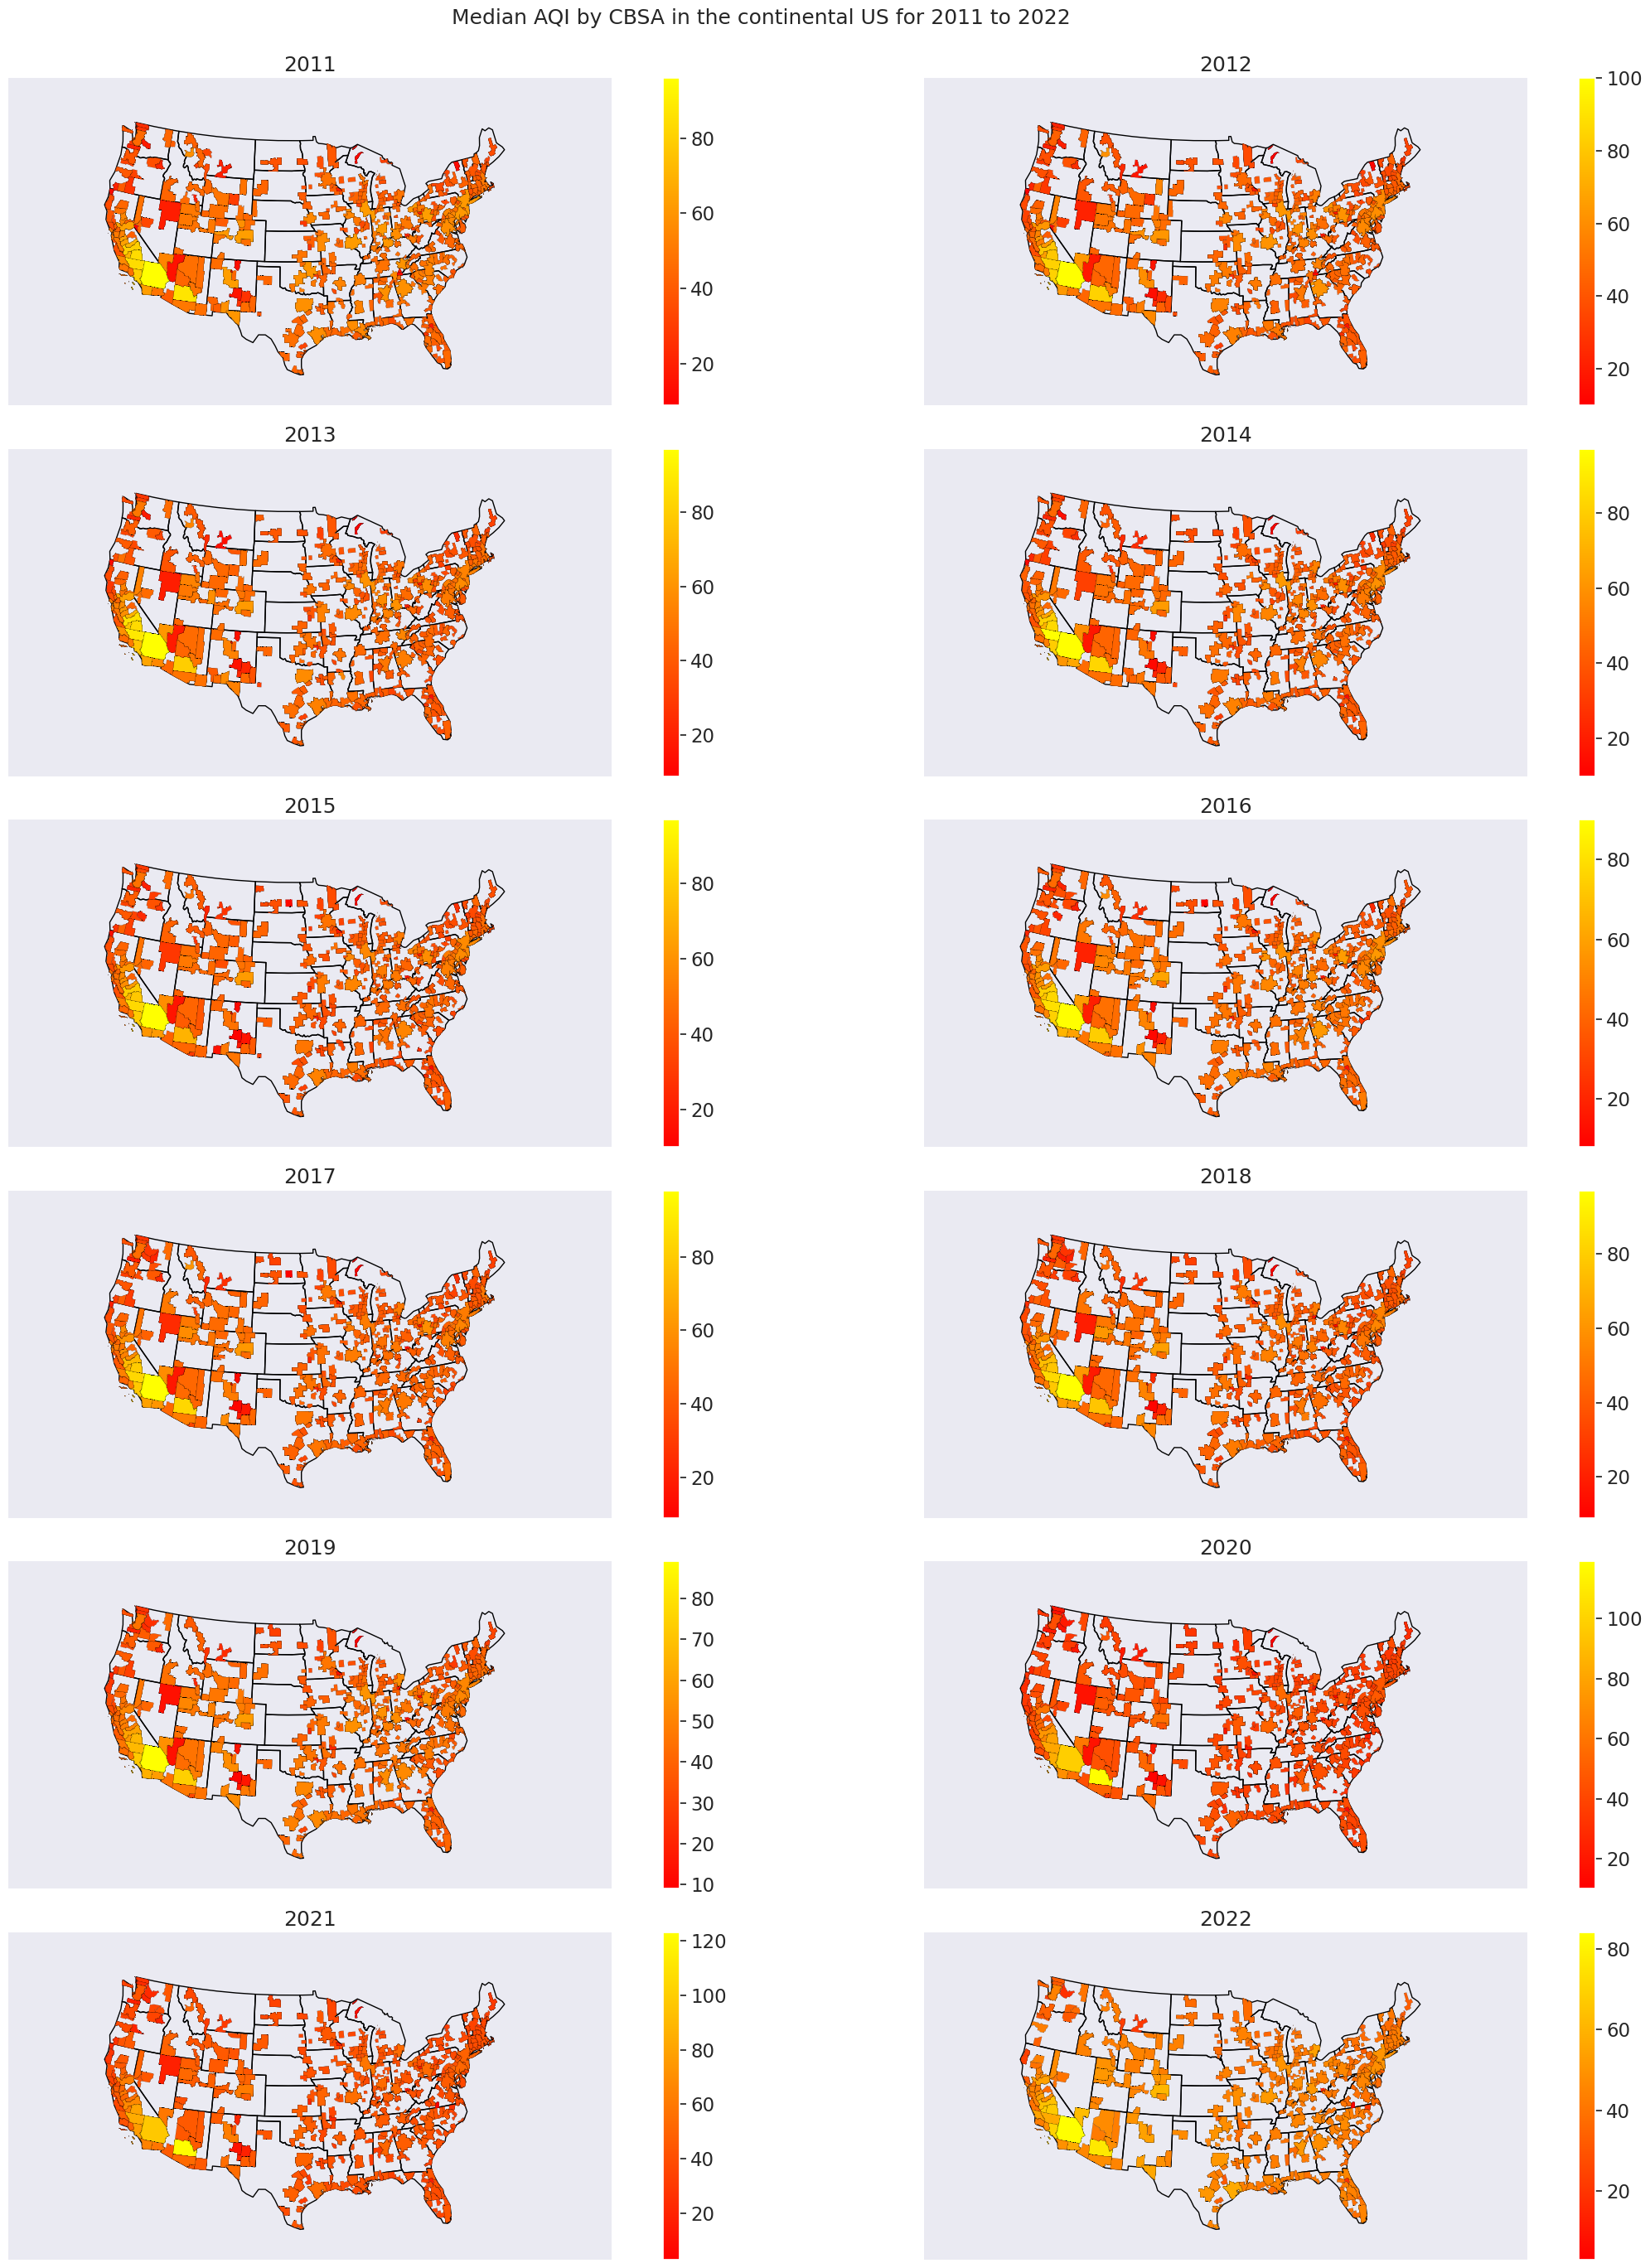

In [12]:
fig2, axarr2 = plt.subplots(
    6,
    2,
    figsize=(24, 28),
    subplot_kw={"projection": projection},
    sharex=True,
    sharey=True,
    squeeze=True,
)
for year, ax in zip(list(range(2011, 2023)), chain.from_iterable(axarr2)):
    gplt.polyplot(
        shapedata,
        projection=gcrs.AlbersEqualArea(
            central_latitude=39.8282, central_longitude=-98.5795
        ),
        ax=ax,
    )
    gplt.choropleth(
        df2.loc[year],
        hue="Median AQI",
        ax=ax,
        legend=True,
        edgecolor="black",
        linewidth=0.1,
        cmap="autumn",
    )
    ax.set_title(f"{year}", fontsize=18)
fig2.tight_layout()
fig2.subplots_adjust(top=0.95)
fig2.suptitle("Median AQI by CBSA in the continental US for 2011 to 2022", fontsize=18)
None

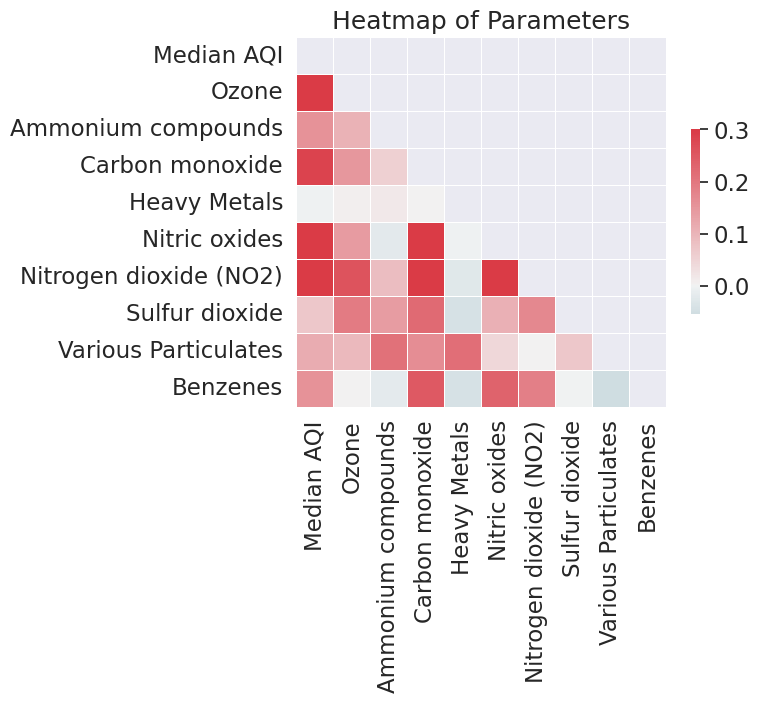

In [21]:
corr = df2[parameters].corr()

# Generate a mask for the top right so we only generate one correlation per 
# pair of factors.
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Generate custom color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create figure using seaborn:
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap.set(title='Heatmap of Parameters')
None

In [18]:
#Export data if data processing has changed
df = df.set_crs(crs)
healthdata = healthdata.set_crs(crs)
df.drop(columns="geometry").to_csv(utils.PROJECT_ROOT / "data/processed/processed1.csv", index=False)
df[["CBSAFP", "geometry"]].drop_duplicates().to_file(utils.PROJECT_ROOT / "data/processed/geodata1.geojson", driver='GeoJSON', engine=("pyogrio" if PYOGRIO_INSTALLED else None))
healthdata.to_file(utils.PROJECT_ROOT / "data/processed/heath1.geojson", driver='GeoJSON', engine=("pyogrio" if PYOGRIO_INSTALLED else None))